### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)

<img src="images/fourbar.png">


In [35]:
%load_ext ipydex.displaytools
%matplotlib inline

import os
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing
import symbtools as st
import symbtools.modeltools as mt
import symbtools.visualisation as vt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)
import scipy.integrate as sc_integrate
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL # Imports the solver ODASSL from Assimulo
from assimulo.problem import Implicit_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

The ipydex.displaytools extension is already loaded. To reload it, use:
  %reload_ext ipydex.displaytools


In [36]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 2
nq = 1
n = np + nq
pp = st.symb_vector("p1:{}".format(np+1)) ##:T
qq = st.symb_vector("q1:{}".format(nq+1)) ##:T


aa = st.symb_vector("a1:{}".format(nq+1)) ##:T

ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad, tthetadd)

---

---

---

---

---

---

In [37]:
params = sp.symbols('s1, s2, s3, m1, m2, m3, J1, J2, J3, l1, l2, l3, l4, kappa1, kappa2, g')
parameter_values = list(dict(s1=1/2, s2=1/2, s3=1/2, m1=1, m2=1, m3=3, J1=1/12 , J2=1/12, J3=1/12,
                             l1=0.8, l2=1.5, l3=1.5, l4=2, kappa1=3/2 , kappa2=14.715, g=9.81).items())
st.make_global(params)

# ttau = sp.symbols('tau')
tau1, tau2 = ttau = st.symb_vector("tau1, tau2")


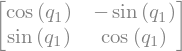

In [38]:
Rz(q1) # Rotationsmatirx

Specify the geometry (joints G and centers of masses S)

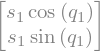

---

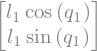

---

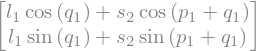

---

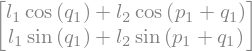

---

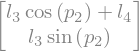

---

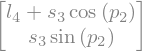

---

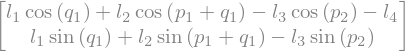

---

In [39]:
# uni vectors

ex = sp.Matrix([1, 0]) 
ey = sp.Matrix([0, 1]) 

# Basis 1 und 2
B1 = sp.Matrix([0, 0])
B2 = sp.Matrix([l4, 0])

# Coordinates two link manipulator
S1 = Rz(q1)*ex*s1 ##:

G1 = Rz(q1)*ex*l1 ##:

S2 = G1 + Rz(q1 + p1)*ex*s2 ##:

G2 = G1 + Rz(q1 + p1)*ex*l2 ##:


# one link manipulator
G2b = B2 + Rz(p2)*ex*l3 ##:

S3 = B2 + Rz(p2)*ex*s3 ##:

constraints = sp.Matrix([G2 - G2b]) ##:


# Time derivative
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta))

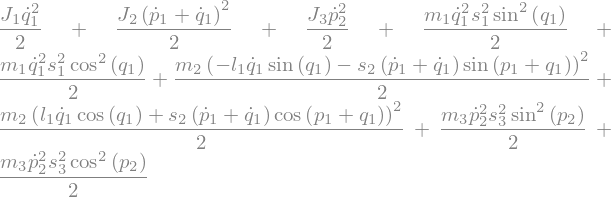

---

---

In [40]:
# kinetic energy

T_rot = (J1*qdot1**2 + J2*(qdot1 + pdot1)**2 + J3*(pdot2)**2)/2
T_trans = ( m1*Sd1.T*Sd1  +  m2*Sd2.T*Sd2 +  m3*Sd3.T*Sd3 )/2

T = T_rot + T_trans[0] ##:

# potential energy
V = m1*g*S1[1] + m2*g*S2[1] + m3*g*S3[1] ##:

---

The next cell draws the fourbar and allows to interactively test the kinematics of the mechanism.

Use the sliders to adjust the coordinates. Activate the checkbox to respect the linkage constraints. Note that you can choose the keyword argument `free_vars` to be one of `q1`, `p1`, `p2`.

---

In [41]:
# useful to test recent development of the lib


import importlib as il
il.reload(vt)


<module 'symbtools.visualisation' from '/home/wredi/.local/lib/python3.8/site-packages/symbtools/visualisation.py'>

In [48]:
vis = vt.Visualiser(ttheta, xlim=(-2, 4), ylim=(-3, 3))
vis.add_linkage(st.col_stack(B1, G1, G2,).subs(parameter_values))
vis.add_linkage(st.col_stack(G2b, B2).subs(parameter_values))


cnstrs = constraints.subs(parameter_values)

# Note: There are two possibilities for the kinematic chain to close (two solutions to the algebraic constraints)

# prefer "upward solution"
vis.interact(p1=(-4, 4, .1, pi/2), free_vars=q1, constraints=cnstrs)

# prefer "downward solution"
# vis.interact(p1=(-4, 4, .1, -pi/2), p2=(-4, 4, .1, -2.1), free_vars=q1, constraints=cnstrs)

interactive(children=(Checkbox(value=False, description='solve constraints (fmin)'), FloatSlider(value=1.57079…

In [49]:
print(list(npy.arange(3)))

[0, 1, 2]


In [50]:
external_forces = [0 , 0, tau1]

%time mod = mt.generate_symbolic_model(T, V, ttheta, external_forces, constraints=constraints)


CPU times: user 13 s, sys: 0 ns, total: 13 s
Wall time: 13 s


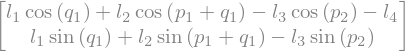

In [51]:
# condition that endeffectors of the two manipulators are at the same place (x and y)

mod.constraints

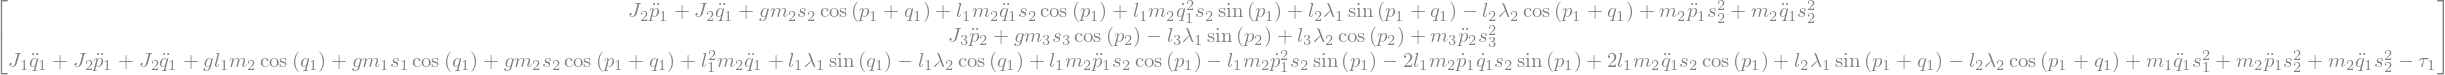

In [52]:
# ODE-part oft the equation

mod.eqns

### Creation of DAE System

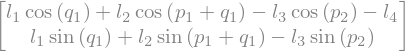

In [53]:
mod.constraints

In [54]:
# generate a dae object

dae = mod.calc_dae_eq(parameter_values)
dae.generate_eqns_funcs()

In [55]:
# show dae variables

dae.yy ##:T
dae.yyd ##:T

---

---

### Calculate consistent initial values by optimization (with given hints)

In [56]:
yy0, yyd0 = dae.calc_consistent_init_vals(p1=0.3) ##:

t0 = 0


# check if all values are almost zero (-> initial values fulfill the model)
assert npy.allclose(dae.model_func(t0, yy0, yyd0), 0)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 91
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 67


(yy0, yyd0) := (array([ 0.3       ,  1.74961317,  0.50948621,  0.        ,  0.        ,  0.        , -0.27535424,  0.5455313 ]),
 array([  0.        ,   0.        ,   0.        ,  23.53968609,   2.82766884, -14.48960943,  -0.        ,   0.        ]))

---

In [57]:
model = Implicit_Problem(dae.model_func, yy0, yyd0, t0)
model.name = 'fourbar linkage'

# indicate which components of y are differential (1) and which are purely algebraic (0)
# model.algvar = dae.diff_alg_vars ##:

sim = ODASSL(model)
# sim.suppress_alg = True #Necessary to set to True for >1 index problem

# values <= 30 produce lots of output
sim.verbosity = 0

In [58]:
tfinal = 10.0        # Specify the final time
ncp = 500            # Number of communication points (number of return points)

# takes about 48 seconds
tt_sol, yy_sol, yyd_sol = sim.simulate(tfinal, ncp) 

No initialization defined for the problem.
No finalization defined for the problem.
Final Run Statistics: fourbar linkage 

 Number of steps                           : 1832
 Number of function evaluations            : 4194
 Number of Jacobian evaluations            : 129
 Number of error test failures             : 36
 Number of nonlinear convergence failures  : 0

Solver options:

 Solver                  : ODASSL 
 Tolerances (absolute)   : 1e-06
 Tolerances (relative)   : 1e-06

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 4.56476582599862 seconds.


In [59]:
ttheta_sol = yy_sol[:, :mod.dae.ntt]
ttheta_d_sol = yy_sol[:, mod.dae.ntt:mod.dae.ntt*2]

Text(0.5, 1.0, 'angular velocities')

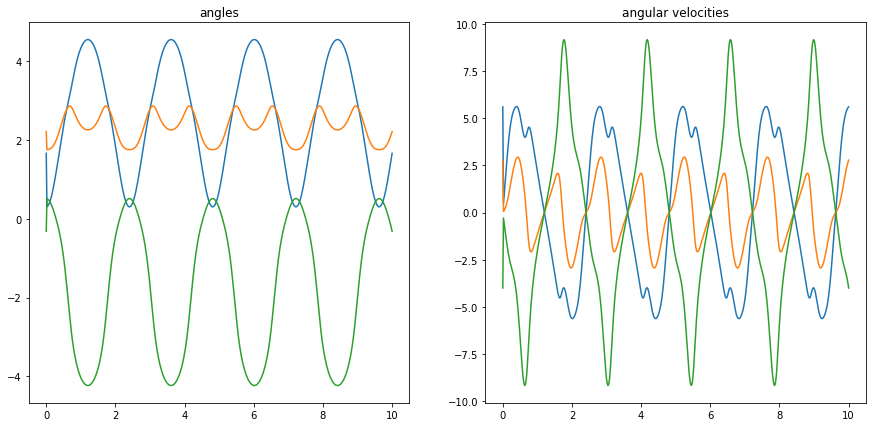

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7)); plt.sca(ax1)

ax1.plot(tt_sol, ttheta_sol)
ax1.set_title("angles")

ax2.plot(tt_sol, ttheta_d_sol)
ax2.set_title("angular velocities")

####  Visualization and Animation

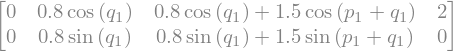

---

In [61]:
joint_pos_expr = st.col_stack(B1, G1, G2, B2).subs(parameter_values) ##:
joint_pos_func = st.expr_to_func(mod.tt, joint_pos_expr, keep_shape=True)

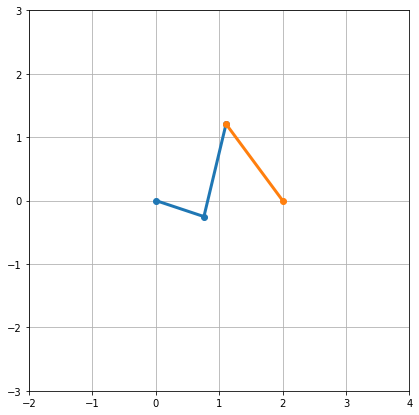

In [62]:
# Create object for Animation

simanim = vt.SimAnimation(mod.xx[:3], tt_sol, yy_sol[:, :3], figsize=(14, 7))
simanim.add_visualiser(vis)

# plot first frame
simanim.plot_frame(0)

In [23]:
# this might need to be adapted on other systems

plt.rcParams["animation.codec"] = "libvpx-vp9"  # codec for webm
plt.rcParams['animation.ffmpeg_path'] = os.path.join(os.getenv("CONDA_PREFIX"), "bin", "ffmpeg")
# plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
# writer = animation.FFMpegWriter(fps=30)

fname="fourbar_linkage_free_movement2.webm"

# this might take some 1e1 seconds
# simanim.save(fname, dpi=30)

In [24]:
vt.display_video_file(fname)